# Main Notebook

In [1]:
import re
import os
import spacy
nlp = spacy.load("en_core_web_sm")

## Parse Data

### coca-samples-text

In [2]:
def parse_articles_text(file_text): 
    article_texts = file_text.split("\n")

    articles = []
    for article_text in article_texts: 
        if len(article_text) == 0: 
            continue
        
        pattern = r'@@\d+ '
        rv = re.findall(pattern, article_text[:20])
        if len(rv) == 0: 
            continue
        article_number = int(rv[0][2:-1])
        print(f"article_number: {article_number}")
        article_doc = nlp(article_text)
        article = {"number" : article_number, "doc" : article_doc}
        
        articles.append(article)
    
    if len(articles) == 0: 
        return None
    return articles

In [3]:
def parse_filename_text(directory, filename): 
    print(f"filename: {filename}")
    file = open(directory + filename, "r", encoding="ISO-8859-1")
    file_text = file.read()
    file.close()
    
    articles = parse_articles_text(file_text)
    if articles == None: 
        return None
    file = {"filename" : filename, "articles" : articles}
    return file

In [4]:
def get_files_text(directory): 
    files = []
    for filename in os.listdir(directory):
        if not filename.endswith(".txt"):
            continue
        
        file = parse_filename_text(directory, filename)
        if file == None: 
            continue
        files.append(file)
    return files

## Build Data

In [5]:
import numpy as np
np.random.seed(31415)
from sklearn.model_selection import train_test_split

In [6]:
%%time
text_directory = "data/coca-samples-text/"
label1, label2 = "spok", "fic"
# text_files = get_files_text(text_directory)

# THIS WAS TAKING TOO LONG SO I AM ONLY DOING SPOK AND TVM
# ['text_news.txt', 'text_fic.txt', 'text_web.txt', 'text_spok.txt', 'text_tvm.txt', 'text_blog.txt', 'text_acad.txt', 'text_mag.txt']
text_files = [parse_filename_text(text_directory, f"text_{label1}.txt"), parse_filename_text(text_directory, f"text_{label2}.txt")]

filename: text_spok.txt
article_number: 17141
article_number: 21741
article_number: 207541
article_number: 207641
article_number: 220641
article_number: 220741
article_number: 221141
article_number: 221241
article_number: 221341
article_number: 221441
article_number: 221541
article_number: 221641
article_number: 221741
article_number: 222141
article_number: 222241
article_number: 222341
article_number: 222441
article_number: 222541
article_number: 222741
article_number: 222841
article_number: 222941
article_number: 223041
article_number: 223141
article_number: 223241
article_number: 223341
article_number: 223441
article_number: 223541
article_number: 223941
article_number: 224241
article_number: 224341
article_number: 224541
article_number: 224641
article_number: 224741
article_number: 224841
article_number: 224941
article_number: 225041
article_number: 225141
article_number: 225241
article_number: 225341
article_number: 225441
article_number: 225541
article_number: 225641
article_numb

article_number: 1012441
article_number: 1012641
article_number: 1012741
article_number: 1012941
article_number: 1013041
article_number: 1013241
article_number: 1013341
article_number: 1013441
article_number: 1013541
article_number: 1013641
article_number: 1013741
article_number: 1013941
article_number: 1014141
article_number: 1014241
article_number: 1014441
article_number: 1014941
article_number: 1015341
article_number: 1015441
article_number: 1015541
article_number: 1015641
article_number: 1015741
article_number: 1015841
article_number: 1016041
article_number: 1016141
article_number: 1016441
article_number: 1016541
article_number: 1016641
article_number: 1016741
article_number: 1016841
article_number: 1017241
article_number: 1017341
article_number: 1017541
article_number: 1017841
article_number: 1018241
article_number: 1018541
article_number: 1018641
article_number: 1018841
article_number: 1018941
article_number: 1030341
article_number: 1030741
article_number: 1030841
article_number: 

In [7]:
def build_data(label1, label2): 
    text_file1 = [file for file in text_files if label1 in file["filename"]][0]
    text_file2 = [file for file in text_files if label2 in file["filename"]][0]
    
    X, Y = [], []
    for article in text_file1["articles"]: 
        X.append(article)
        Y.append(label1)
    
    for article in text_file2["articles"]: 
        X.append(article)
        Y.append(label2)
    return (X, Y)

In [8]:
X, Y = build_data(label1, label2)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0)

### Some statistics for the paper

In [9]:
full_data = []
for i in range(len(X)): 
    a = X[i]
    a["label"] = Y[i]
    full_data.append(a)

In [10]:
print(f"Label: {label1}")
rv_1 = np.mean([len(a["doc"]) for a in full_data if a["label"] == label1])        
print(f"Average number of words: {rv_1}")

print(f"Label: {label2}")
rv_2 = np.mean([len(a["doc"]) for a in full_data if a["label"] == label2])        
print(f"Average number of words: {rv_2}")

Label: spok
Average number of words: 4626.6045627376425
Label: fic
Average number of words: 5284.076642335766


## Build Classifier

In [11]:
import json
import nltk
from sklearn import linear_model
from scipy import sparse
from collections import Counter
import operator

In [12]:
def print_weights(clf, vocab, n=10):
    weights=clf.coef_[0]
    reverse_vocab=[None]*len(weights)
    for k in vocab:
        reverse_vocab[vocab[k]]=k

    print(f"Class 1: {clf.classes_[0]}")
    for feature, weight in sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))[:n]:
        print("%.3f\t%s" % (weight, feature))

    print()

    print(f"Class 2: {clf.classes_[1]}")
    for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
        print("%.3f\t%s" % (weight, feature))

In [13]:
def build_features(dataX, feature_functions):
    
    """ This function featurizes the data according to the list of parameter feature_functions """
    
    data=[]
    for tokens in dataX:
        feats={}
        
        for function in feature_functions:
            feats.update(function(tokens))

        data.append(feats)
    return data

In [14]:
def features_to_ids(data, feature_vocab):
    
    """ 
    
    This helper function converts a dictionary of feature names to a sparse representation
 that we can fit in a scikit-learn model.  This is important because almost all feature 
 values will be 0 for most documents (note: why?), and we don't want to save them all in 
 memory.

    """
    new_data=sparse.lil_matrix((len(data), len(feature_vocab)))
    for idx,doc in enumerate(data):
        for f in doc:
            if f in feature_vocab:
                new_data[idx,feature_vocab[f]]=doc[f]
    return new_data

In [15]:
def create_vocab(data, top_n=None):
    
    """ 
    
    This helper function converts a dictionary of feature names to unique numerical ids. 
    top_n limits the features to only the n most frequent features observed in the training data 
    (in terms of the number of documents that contains it).
    
    """
    
    counts=Counter()
    for doc in data:
        for feat in doc:
            counts[feat]+=1

    feature_vocab={}

    for idx, (k, v) in enumerate(counts.most_common(top_n)):
        feature_vocab[k]=idx
                
    return feature_vocab

In [16]:
def pipeline(trainX, devX, trainY, devY, feature_functions):

    """ This function evaluates a list of feature functions on the training/dev data arguments """
    
    trainX_feat=build_features(trainX, feature_functions)
    devX_feat=build_features(devX, feature_functions)

    # just create vocabulary from features in *training* data.
    feature_vocab=create_vocab(trainX_feat, top_n=100000)

    trainX_ids=features_to_ids(trainX_feat, feature_vocab)
    devX_ids=features_to_ids(devX_feat, feature_vocab)
    
    clf = linear_model.LogisticRegression(C=100, solver='lbfgs', penalty='l2', max_iter=10000)
    clf.fit(trainX_ids, trainY)
    print("Accuracy: %.3f" % clf.score(devX_ids, devY))
    
    return clf, feature_vocab

## Build Features

In [17]:
def normalize_feats(feats): 
    total = sum(list(feats.values()))
    for (key, value) in feats.items(): 
        feats[key] = value / total
    return feats

In [18]:
def sentence_length(article): 
    doc = article["doc"]
    
    feats = {}
    for sentence in list(doc.sents): 
        num_tokens = len(list(doc.sents))
        feat_name = f"sentence_length_{num_tokens}"
        feats[feat_name] = feats.get(feat_name, 0) + 1
    return normalize_feats(feats)

In [19]:
def parts_of_speech(article): 
    doc = article["doc"]
    
    feats = {}
    for token in doc: 
        feat_name = f"POS_{token.pos_}"
        feats[feat_name] = feats.get(feat_name, 0) + 1
    return normalize_feats(feats)

In [20]:
hedging_file = open("data/hedging_data.txt")
hedging_text = hedging_file.read()
hedging_file.close()
hedging_lst = [h for h in hedging_text.split("\n") if ("%" not in h and len(h) > 2)]
print(hedging_lst)

['largely', 'generally', 'often', 'rarely', 'sometimes', 'frequently', 'occasionally', 'seldom', 'usually', 'most', 'several', 'some', 'almost', 'practically', 'apparently', 'virtually', 'basically', 'approximately', 'roughly', 'somewhat', 'somehow', 'partially', 'actually', 'like', 'something', 'someone', 'somebody', 'somewhere', 'think', 'thinks', 'thought', 'believe', 'believed', 'believes', 'consider', 'considers', 'considered', 'assume', 'assumes', 'assumed', 'understand', 'understands', 'understood', 'find', 'found', 'finds', 'appear', 'appears', 'appeared', 'seem', 'seems', 'seemed', 'suppose', 'supposes', 'supposed', 'guess', 'guesses', 'guessed', 'estimate', 'estimates', 'estimated', 'speculate', 'speculates', 'speculated', 'suggest', 'suggests', 'suggested', 'may', 'could', 'should', 'might', 'surely', 'probably', 'likely', 'maybe', 'perhaps', 'unsure', 'probable', 'unlikely', 'possibly', 'possible', 'read', 'say', 'says', 'looks like', 'look like', "don't know", 'necessarily

In [21]:
def hedging_feature(article): 
    doc = article["doc"]
    
    feats = {}
    for sentence in list(doc.sents): 
        for hedge in hedging_lst: 
            if hedge in sentence.string: 
                feat_name = f"hedge_{hedge}"
                feats[feat_name] = feats.get(feat_name, 0) + 1
    return normalize_feats(feats)

In [22]:
evidential_list = ["Heard", "say", "They say", "It seems", "I feel that", "It sounds like", "From my experience", "It is said that", 
            "I see", "I hear", "I gather", "I'm told", "They say that", "I doubt", "Apparently", "Seemingly", "They had"
            "probably", "think", "obviously", "saw", "must", "reportedly", "looks like"]

In [23]:
def evidential_feature(article): 
    doc = article["doc"]
    
    feats = {}
    for sentence in list(doc.sents): 
        for evidential in evidential_list: 
            if evidential in sentence.string: 
                feat_name = f"evidential_{evidential}"
                feats[feat_name] = feats.get(feat_name, 0) + 1
    return normalize_feats(feats)

## Put It All Together

In [24]:
features = [sentence_length, parts_of_speech, hedging_feature, evidential_feature]

In [25]:
%%time
clf, vocab = pipeline(trainX, testX, trainY, testY, features)

Accuracy: 0.917
CPU times: user 12min 53s, sys: 7.6 s, total: 13min 1s
Wall time: 13min 2s


In [26]:
print_weights(clf, vocab, n=50)

Class 1: fic
-9.795	hedge_could
-8.952	POS_VERB
-8.810	hedge_around
-8.572	hedge_like
-8.154	hedge_thought
-7.390	POS_X
-6.876	hedge_says
-5.991	sentence_length_397
-5.852	hedge_would
-5.670	sentence_length_378
-5.044	sentence_length_320
-4.937	POS_NOUN
-4.880	POS_DET
-4.803	hedge_might
-4.781	sentence_length_808
-4.637	hedge_read
-4.436	sentence_length_62
-4.416	sentence_length_239
-4.399	sentence_length_49
-4.398	evidential_I hear
-4.327	sentence_length_143
-4.312	sentence_length_75
-4.267	sentence_length_26
-4.208	sentence_length_66
-4.151	sentence_length_3491
-3.964	sentence_length_45
-3.861	sentence_length_278
-3.745	hedge_say
-3.509	sentence_length_355
-3.462	evidential_must
-3.449	hedge_seemed
-3.363	sentence_length_652
-3.351	hedge_little
-3.281	sentence_length_713
-3.233	sentence_length_724
-3.212	sentence_length_1190
-3.173	sentence_length_748
-3.166	sentence_length_468
-3.135	sentence_length_260
-3.124	hedge_always
-2.998	sentence_length_318
-2.997	sentence_length_292
-2.926

## SAVE & LOAD MODEL

In [ ]:
"""
import pickle
from datetime import datetime

# save models
dt_string = datetime.now().strftime("%d_%m_%Y %H_%M_%S")
clf_name = f"models/clf {dt_string}.sav"
vocab_name = f"models/vocab {dt_string}.sav"
pickle.dump(clf, open(clf_name, 'wb'))
pickle.dump(vocab, open(vocab_name, 'wb'))

# load models
loaded_clf = pickle.load(open(clf_name, 'rb'))
loaded_vocab = pickle.load(open(vocab_name, 'rb'))
"""

## Parse Gutenberg Data

### Read in Gutenberk Texts from before 1923 from [https://github.com/dbamman/litbank]

#### Read in Metadata from ReadMe

In [27]:
file = open("data/litbank_metadata.txt")
litbank_metadata_text = file.read()
file.close()

litbank_metadata = []
for line in litbank_metadata_text.split("\n"): 
    try: 
        items = line.split("|")
        row = {'Gutenberg ID' : int(items[1]), 'Date' : int(items[2]), 'Author' : items[3], 'Title' : items[4]}
        litbank_metadata.append(row)
    except: 
        print(f"skipping this line: {line}")

skipping this line: |Gutenberg ID|Date|Author|Title|
skipping this line: |---|---|---|---|


In [28]:
def get_guten_year(guten_id): 
    for row in litbank_metadata: 
        if row['Gutenberg ID'] == guten_id: 
            return row['Date']
    return None

#### Read in Texts

In [29]:
import random 
random.seed(190)
"""
    Computational limits do not allow us to run spacy on the entirety of one gutenberg texts. 
    Even running spacy on text[:nlp.max_length] leads to waiting for 45 minutes to load in the spacy data, 
    let alone parsing it for features and classifier
    Thus, we have decided to take smaller, random chunks from throughout each of the gutenberg texts
"""
NUM_SAMPLES = 10

In [30]:
def parse_text_litbank(text, number=None, filename=None): 
    doc = nlp(text)
    article = {"doc" : doc}
    if number != None: 
        article["number"] = number
    if filename != None: 
        article["filename"] = filename
        pattern = r"\d+"
        guten_id = re.findall(pattern, filename)
        if len(guten_id) > 0: 
            guten_id = int(guten_id[0])
            article["id"] = guten_id
            guten_year = get_guten_year(guten_id)
            if guten_year != None: 
                article["year"] = guten_year
    return article

In [31]:
def build_litbank_data(): 
    X = []
    number = 0
    for filename in os.listdir(litbank_dir):
        if not filename.endswith(".txt"): 
            continue
        print(f"filename: {filename}")
        full_filename = os.path.join(litbank_dir, filename)
        file = open(full_filename)
        text = file.read()
        file.close()
        
        
        chunk_size = nlp.max_length // 100
        chunk_texts = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
        chunk_sample = random.sample(chunk_texts, min(NUM_SAMPLES, len(chunk_texts)))
        for chunk in chunk_sample: 
            X.append(parse_text_litbank(chunk, number=number, filename=filename))
            number += 1
    
    return X

In [32]:
%%time
litbank_dir = "../litbank/original/"
X_litbank = build_litbank_data()

filename: 730_oliver_twist.txt
filename: 76_adventures_of_huckleberry_finn.txt
filename: 74_the_adventures_of_tom_sawyer.txt
filename: 766_david_copperfield.txt
filename: 345_dracula.txt
filename: 105_persuasion.txt
filename: 18581_adrift_in_new_york_tom_and_florence_braving_the_world.txt
filename: 45_anne_of_green_gables.txt
filename: 3268_the_mysteries_of_udolpho.txt
filename: 6593_history_of_tom_jones_a_foundling.txt
filename: 1206_the_flying_u_ranch.txt
filename: 969_the_tenant_of_wildfell_hall.txt
filename: 5348_ragged_dick_or_street_life_in_new_york_with_the_bootblacks.txt
filename: 84_frankenstein_or_the_modern_prometheus.txt
filename: 711_allan_quatermain.txt
filename: 351_of_human_bondage.txt
filename: 215_the_call_of_the_wild.txt
filename: 1327_elizabeth_and_her_german_garden.txt
filename: 78_tarzan_of_the_apes.txt
filename: 60_the_scarlet_pimpernel.txt
filename: 36_the_war_of_the_worlds.txt
filename: 599_vanity_fair.txt
filename: 2852_the_hound_of_the_baskervilles.txt
filena

### Read in More Gutenberg Texts after 1923

In [33]:
def parse_text_recent_guten(text, number=None, filename=None): 
    doc = nlp(text)
    article = {"doc" : doc}
    if number != None: 
        article["number"] = number
    if filename != None: 
        article["filename"] = filename
        pattern = r"\d+"
        rv = re.findall(pattern, filename)
        if len(rv) == 2: 
            article["id"] = int(rv[0])
            article["year"] = int(rv[1])
    return article

In [34]:
def build_recent_guten_data(): 
    X = []
    number = 0
    for filename in os.listdir(recent_guten_dir):
        if not filename.endswith(".txt"): 
            continue
        print(f"filename: {filename}")
        full_filename = os.path.join(recent_guten_dir, filename)
        file = open(full_filename)
        text = file.read()
        file.close()
        
        """
        Computational limits do not allow us to run spacy on the entirety of one gutenberg texts. 
        Even running spacy on text[:nlp.max_length] --> waiting 45 minutes to load in the spacy data, 
        let alone parsing it for features and classifier
        Thus, we have decided to take smaller, random chunks from throughout each of the gutenberg texts
        """
        chunk_size = nlp.max_length // 100
        chunk_texts = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
        chunk_sample = random.sample(chunk_texts, min(NUM_SAMPLES, len(chunk_texts)))
        for chunk in chunk_sample: 
            X.append(parse_text_recent_guten(chunk, number=number, filename=filename))
            number += 1
    
    return X

In [35]:
%%time
recent_guten_dir = "data/recent_guten"
X_recent_guten = build_recent_guten_data()

filename: 63426-his_chap-1955.txt
filename: 63942-techmen_1954.txt
filename: 63950-star_ship-1950.txt
filename: 62864-huey_long-1963.txt
filename: 63956-queen_catacombs-1949.txt
filename: 63960-rebel_of_valkyr-1950.txt
filename: 61278_too_many_eggs-1962.txt
filename: 63990-palimpsest-1951.txt
filename: 61430-manners_customs_thrid-1963.txt
filename: 63982-conquistadors_come-1951.txt
filename: 59288-french_painting-1959.txt
filename: 61105-knitting-1970.txt
CPU times: user 31.6 s, sys: 43.6 ms, total: 31.6 s
Wall time: 31.8 s


### Put together All Gutenberg Texts

In [36]:
X_guten = X_litbank + X_recent_guten

## Predict on Litbank

In [37]:
def predict_data(X): 
    X_feat = build_features(X, features)
    X_ids=features_to_ids(X_feat, vocab)
    return (clf.predict(X_ids), clf.predict_proba(X_ids))

In [38]:
%%time
(classes, probas) = predict_data(X_guten)
print(f"classes: {classes}")
print(f"probas: {probas}")

classes: ['fic' 'fic' 'fic' ... 'fic' 'fic' 'spok']
probas: [[0.89989229 0.10010771]
 [0.69151525 0.30848475]
 [0.85311832 0.14688168]
 ...
 [0.99772399 0.00227601]
 [0.95969002 0.04030998]
 [0.0672978  0.9327022 ]]
CPU times: user 6min 41s, sys: 847 ms, total: 6min 42s
Wall time: 6min 42s


In [39]:
num_classified_label1 = len([c for c in classes if c == label1])
num_classified_label2 = len([c for c in classes if c == label2])
print(f"Number of {label1}: {num_classified_label1}")
print(f"Number of {label2}: {num_classified_label2}")
"""
Defintion of Accuracy using sklearn.metrics.accuracy_score
return the fraction of correctly classified samples (float), else returns the number of correctly classified samples (int).
"""
accuracy = num_classified_label2 / (num_classified_label1 + num_classified_label2)
print(f"Accuracy: {accuracy}")

Number of spok: 136
Number of fic: 942
Accuracy: 0.8738404452690167


In [40]:
full_guten = []
for i in range(len(X_guten)): 
    a = X_guten[i]
    a["class"] = classes[i]
    a["proba"] = probas[i]
    full_guten.append(a)

In [41]:
full_guten[0].keys()

dict_keys(['doc', 'number', 'filename', 'id', 'year', 'class', 'proba'])

## Diagrams of Litbank Data

In [ ]:
import matplotlib.pyplot as plt

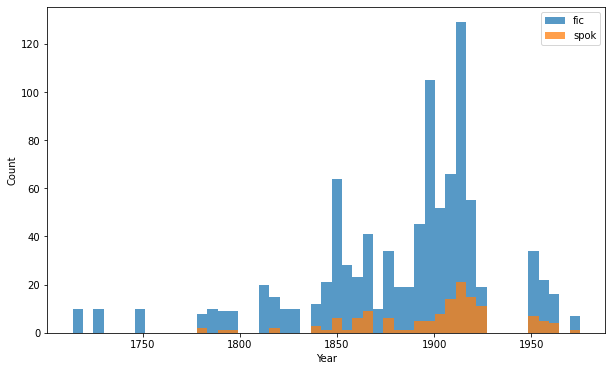

In [50]:
fic_years = [a["year"] for a in full_guten if "fic" in a["class"]]
spok_years = [a["year"] for a in full_guten if "spok" in a["class"]]
all_years = [a["year"] for a in full_guten]

plt.gcf().set_size_inches(10, 6)

bins = np.linspace(min(all_years) - 5, max(all_years) + 5, num=50)
plt.hist(fic_years, bins=bins, alpha=0.75, label="fic")
plt.hist(spok_years, bins=bins, alpha=0.75, label="spok")

plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

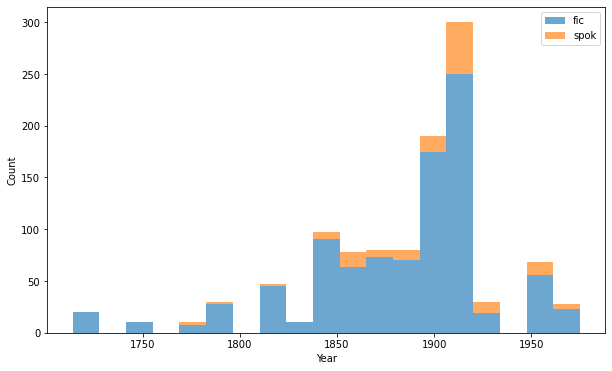

In [58]:
plt.gcf().set_size_inches(10, 6)
bins = np.linspace(min(all_years) - 5, max(all_years) + 5, num=20)
plt.hist((fic_years, spok_years), bins=bins, alpha=0.65, label=("fic", "spok"), histtype='bar', stacked=True)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

No handles with labels found to put in legend.


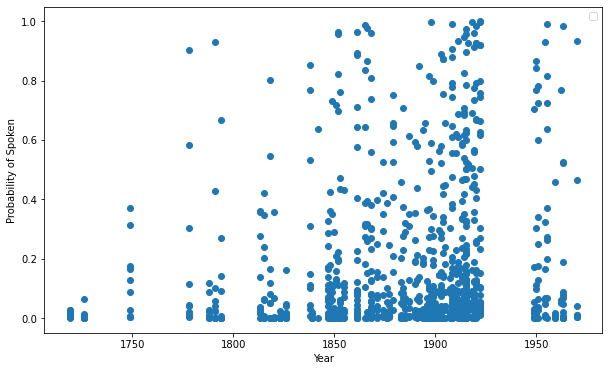

In [61]:
# year of the gutenberg text
x = all_years = [a["year"] for a in full_guten]
# probability of being classified as "spok"
y = [a["proba"][1] for a in full_guten] 

plt.gcf().set_size_inches(10, 6)
plt.scatter(x, y)
plt.xlabel('Year')
plt.ylabel('Probability of Spoken')
plt.legend(loc='upper right')
plt.show()

No handles with labels found to put in legend.


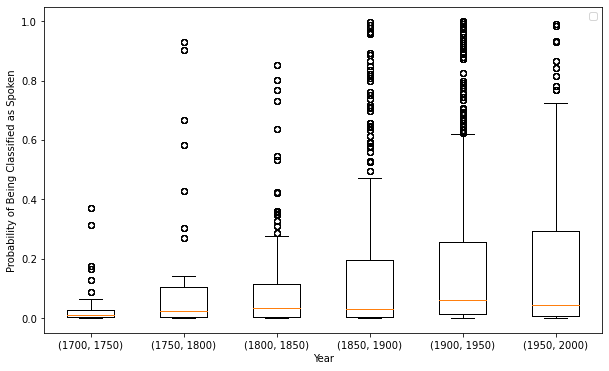

In [80]:
delta = 50
time_periods = [(i, i + delta) for i in range(1700, 2000, delta)]
probas_periods = [[a["proba"][1] for a in full_guten if (a["year"] >= t[0] and a["year"] < t[1])] for t in time_periods]

# plt.gcf().set_size_inches(10, 6)
fig, ax1 = plt.subplots(figsize=(10, 6))
for probas in probas_periods: 
    plt.boxplot(probas_periods)
plt.xticks(list(range(1, len(time_periods) + 1)), [str(t) for t in time_periods])
plt.xlabel('Year')
plt.ylabel('Probability of Being Classified as Spoken')
plt.legend(loc='upper right')
plt.show()

## SAVE & LOAD DATA

In [ ]:
"""
import pickle
from datetime import datetime

dt_string = datetime.now().strftime("%d_%m_%Y %H_%M_%S")

# save COCA data
trainX_name = f"models/trainX {dt_string}.sav"
pickle.dump(trainX, open(trainX_name, 'wb'))

testX_name = f"models/testX {dt_string}.sav"
pickle.dump(testX, open(testX_name, 'wb'))

trainY_name = f"models/trainY {dt_string}.sav"
pickle.dump(trainY, open(trainY_name, 'wb'))

testY_name = f"models/testY {dt_string}.sav"
pickle.dump(testY, open(testY_name, 'wb'))

# save litbank data
X_litbank_name = f"models/X_litbank {dt_string}.sav"
pickle.dump(X_litbank, open(X_litbank_name, 'wb'))

# load COCA data
loaded_trainX = pickle.load(open(trainX_name, 'rb'))
loaded_testX = pickle.load(open(testX_name, 'rb'))
loaded_trainY = pickle.load(open(trainY_name, 'rb'))
loaded_testY = pickle.load(open(testY_name, 'rb'))

#load litbank data
loaded_X_litbank = pickle.load(open(X_litbank_name, 'rb'))
"""